En esta notebook:



*   ETM para LSA
*  vMF para LSA


# ETM para LSA

In [ ]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups

# Descargar el conjunto de datos 20 Newsgroups
newsgroups_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Crear un DataFrame a partir de los datos de newsgroups, incluyendo las etiquetas y los nombres de los tópicos
df_newsgroups = pd.DataFrame({
    'text': newsgroups_data.data,  # Los textos de los documentos
    'label': newsgroups_data.target,  # Las etiquetas de los documentos
    'topic': [newsgroups_data.target_names[label] for label in newsgroups_data.target]  # Los nombres de los tópicos
})

# Guardar el DataFrame en un archivo CSV
df_newsgroups.to_csv('20newsgroups_data_with_topics.csv', index=False)

# Mostrar el DataFrame creado
df_newsgroups.head()  # Mostrar las primeras filas del DataFrame


,text,label,topic
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware


In [ ]:
!pip install -q scikit-learn==1.1.0 octis==1.14.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.25.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.0 which is incompatible.
mlxtend 0.23.2 requires scikit-learn>=1.3.1, but you have scikit-learn 1.1.0 which is incompatible.


In [ ]:
!pip install torch torchvision
!pip install octis
!pip install transformers

In [ ]:
!pip install -q torch torchvision octis gensim

VAMOS a:

implementar un modelo ETM (Embedded Topic Model) usando LSA en cada texto de la columna text del DataFrame df_newsgroups y guardar el resultado como una nueva columna, sigue estos pasos:

Aplicamos el embedding LSA.

Preparar el ETM: Usa un modelo ETM con los embeddings obtenidos de Doc2Vec. Un ETM normalmente necesita representaciones de los textos en un espacio de baja dimensionalidad y una lista de palabras para modelar los temas. Usamos los topicos originales para modelar los temas

Implementar el ETM: usamos una librería como PyTorch para crear y entrenar el ETM. Define una arquitectura que tome los embeddings de LSA como entrada y genere los temas.

Guardar el Output: Luego de entrenar el ETM, aplicamos el modelo a cada documento para generar su asignación de tema. Guarda este output en una nueva columna, por ejemplo, etm_topic.

Calculamos el porcentaje de documentos por topico que fueron asignados correctamente, las correpondientes matrices de confusión y la coherencia c_v.

In [ ]:
!pip install -U scikit-learn


  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.1.0
    Uninstalling scikit-learn-1.1.0:
      Successfully uninstalled scikit-learn-1.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
octis 1.14.0 requires scikit-learn==1.1.0, but you have scikit-learn 1.5.2 which is incompatible.


In [ ]:
!pip install scikit-learn==1.0.2


  Using cached scikit_learn-1.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
Using cached scikit_learn-1.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.25.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
mlxtend 0.23.2 requires scikit-learn>=1.3.1, but you have scikit-learn 1.0.2 which is incompatible.
octis 1.14.0 requires scikit-learn==1.1.0, but you have scikit-learn 1.0.2 which is incompatible.


In [ ]:
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import torch

# Paso 1: Vectorización de los documentos con TF-IDF y reducción de dimensionalidad con LSA
tfidf_vectorizer = TfidfVectorizer(max_features=100000)  # Limita el vocabulario a 5000 palabras
tfidf_matrix = tfidf_vectorizer.fit_transform(df_newsgroups['text'])

# Reducir la dimensionalidad con LSA (TruncatedSVD)
lsa = TruncatedSVD(n_components=100)  # Ajusta el número de componentes según lo necesario
lsa_embeddings = lsa.fit_transform(tfidf_matrix)

# Agregar los embeddings de LSA al DataFrame
df_newsgroups['lsa_vector'] = list(lsa_embeddings)

# Paso 2: Codificar los tópicos en formato numérico
label_encoder = LabelEncoder()
df_newsgroups['topic_encoded'] = label_encoder.fit_transform(df_newsgroups['topic'])

# Paso 3: Implementar el ETM usando PyTorch
# Definir el modelo ETM basado en los embeddings de LSA y tópicos
class ETM(torch.nn.Module):
    def __init__(self, input_dim, num_topics):
        super(ETM, self).__init__()
        self.fc = torch.nn.Linear(input_dim, num_topics)

    def forward(self, x):
        return torch.nn.functional.softmax(self.fc(x), dim=1)

# Configuración de los parámetros del modelo
num_topics = len(df_newsgroups['topic'].unique())
etm_model = ETM(input_dim=100, num_topics=num_topics)  # 50 es la dimensión de los embeddings LSA

# Convertir los embeddings de LSA y las etiquetas de tópicos a tensores
lsa_embeddings_tensor = torch.tensor(df_newsgroups['lsa_vector'].tolist(), dtype=torch.float)
topic_labels = torch.tensor(df_newsgroups['topic_encoded'].values, dtype=torch.long)

# Configuración del optimizador y la función de pérdida
optimizer = torch.optim.Adam(etm_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Entrenamiento básico del ETM
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = etm_model(lsa_embeddings_tensor)
    loss = criterion(outputs, topic_labels)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")

# Paso 4: Asignar temas generados a cada documento
with torch.no_grad():
    df_newsgroups['etm_topic'] = etm_model(lsa_embeddings_tensor).argmax(dim=1).numpy()

# Decodificar los temas generados a etiquetas originales de la columna 'topic'
df_newsgroups['etm_topic'] = label_encoder.inverse_transform(df_newsgroups['etm_topic'])

# Mostrar los primeros resultados
print(df_newsgroups[['text', 'topic', 'etm_topic']].head())



<ipython-input-3-99f52beb6759>:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  lsa_embeddings_tensor = torch.tensor(df_newsgroups['lsa_vector'].tolist(), dtype=torch.float)


Epoch [0/100], Loss: 2.9958
Epoch [10/100], Loss: 2.9922
Epoch [20/100], Loss: 2.9881
Epoch [30/100], Loss: 2.9834
Epoch [40/100], Loss: 2.9777
Epoch [50/100], Loss: 2.9710
Epoch [60/100], Loss: 2.9630
Epoch [70/100], Loss: 2.9538
Epoch [80/100], Loss: 2.9437
Epoch [90/100], Loss: 2.9330
                                                text  \
0  \n\nI am sure some bashers of Pens fans are pr...   
1  My brother is in the market for a high-perform...   
2  \n\n\n\n\tFinally you said what you dream abou...   
3  \nThink!\n\nIt's the SCSI card doing the DMA t...   
4  1)    I have an old Jasmine drive which I cann...   

                      topic                 etm_topic  
0          rec.sport.hockey    soc.religion.christian  
1  comp.sys.ibm.pc.hardware  comp.sys.ibm.pc.hardware  
2     talk.politics.mideast     talk.politics.mideast  
3  comp.sys.ibm.pc.hardware  comp.sys.ibm.pc.hardware  
4     comp.sys.mac.hardware     talk.politics.mideast  


In [ ]:
df_newsgroups[:10]

,text,label,topic,lsa_vector,topic_encoded,etm_topic
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey,"[0.2853483940153972, 0.09348116582272543, 0.01...",10,soc.religion.christian
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware,"[0.11495080606197196, -0.10027886486866873, -0...",3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast,"[0.37882400791493964, -0.06654839963461616, 0....",17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware,"[0.279757336698298, 0.04272709150918395, -0.14...",3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware,"[0.2687014515787101, -0.08736636128162494, -0....",4,talk.politics.mideast
5,\n\nBack in high school I worked as a lab assi...,12,sci.electronics,"[0.16162915734125982, 0.013432018207410478, 0....",12,misc.forsale
6,\n\nAE is in Dallas...try 214/241-6060 or 214/...,4,comp.sys.mac.hardware,"[0.10329795836519323, -0.04365766288863001, 0....",4,rec.sport.hockey
7,"\n[stuff deleted]\n\nOk, here's the solution t...",10,rec.sport.hockey,"[0.23920648967386635, 0.024136855130442583, -0...",10,misc.forsale
8,"\n\n\nYeah, it's the second one. And I believ...",10,rec.sport.hockey,"[0.25137878399957675, 0.0007880081762924739, 0...",10,misc.forsale
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc,"[0.15140447521743722, 0.02087553492682831, 0.0...",19,soc.religion.christian


In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import gensim

# Preprocess text into tokens for coherence calculation
df_newsgroups['tokens'] = df_newsgroups['text'].apply(lambda x: gensim.utils.simple_preprocess(x))

# Group tokens by the assigned ETM topic, and flatten each group to get a single list of words per topic
topic_words = df_newsgroups.groupby('etm_topic')['tokens'].apply(lambda docs: [word for tokens in docs for word in tokens]).tolist()

# Create a Gensim dictionary from all tokens
dictionary = Dictionary(df_newsgroups['tokens'])

# Compute coherence score using c_v (you can change this to u_mass, c_uci, or c_npmi if preferred)
coherence_model = CoherenceModel(topics=topic_words, texts=df_newsgroups['tokens'].tolist(),
                                 dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

print(f"Coherence score for ETM topics: {coherence_score:.4f}")





Coherence score for ETM topics: 0.3664


In [ ]:
# Contar coincidencias entre 'topic' y 'etm_topic'
coincidencias = (df_newsgroups['topic'] == df_newsgroups['etm_topic']).sum()

# Mostrar el número de coincidencias
print(f"El número de documentos en los que coinciden 'topic' y 'etm_topic' es: {coincidencias}")


El número de documentos en los que coinciden 'topic' y 'etm_topic' es: 6689


In [ ]:
num_filas = df_newsgroups.shape[0]
print(f"El número de filas en el DataFrame es: {num_filas}")


El número de filas en el DataFrame es: 18846


In [ ]:
num_filas = 18846
coincidencias = 6689

porcentaje_coincidencias = (coincidencias / num_filas) * 100
print(f"El porcentaje de coincidencias es: {porcentaje_coincidencias:.2f}%")


El porcentaje de coincidencias es: 35.49%


In [ ]:
!pip uninstall scikit-learn -y




Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2


In [ ]:
!pip cache purge


Files removed: 45


In [ ]:
!pip install scikit-learn==1.2.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 47.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
octis 1.14.0 requires scikit-learn==1.1.0, but you have scikit-learn 1.2.2 which is incompatible.


In [ ]:
import pandas as pd

# Crear una tabla de contingencia (confusión) con pandas
matriz_confusion = pd.crosstab(df_newsgroups['topic'], df_newsgroups['etm_topic'], rownames=['Actual'], colnames=['Predicted'])

# Mostrar la matriz de confusión
print(matriz_confusion)



Predicted                 alt.atheism  comp.graphics  comp.os.ms-windows.misc  \
Actual                                                                          
alt.atheism                         1              4                        0   
comp.graphics                       0            357                       13   
comp.os.ms-windows.misc             0             37                      182   
comp.sys.ibm.pc.hardware            0             26                       18   
comp.sys.mac.hardware               0             13                        2   
comp.windows.x                      0             47                       10   
misc.forsale                        0              5                        2   
rec.autos                           0              2                        2   
rec.motorcycles                     0              3                        0   
rec.sport.baseball                  0              8                        0   
rec.sport.hockey            

In [ ]:
!pip install seaborn


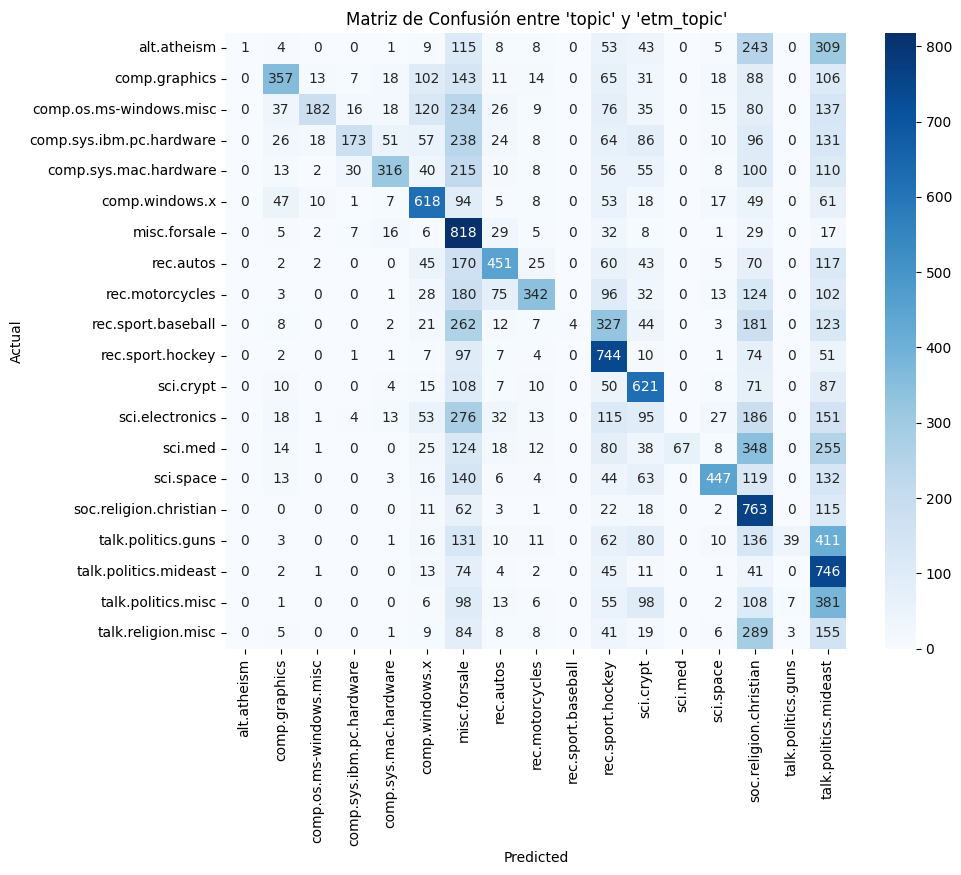

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear la tabla de contingencia como matriz de confusión
matriz_confusion = pd.crosstab(df_newsgroups['topic'], df_newsgroups['etm_topic'], rownames=['Actual'], colnames=['Predicted'])

# Plotear la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Matriz de Confusión entre 'topic' y 'etm_topic'")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


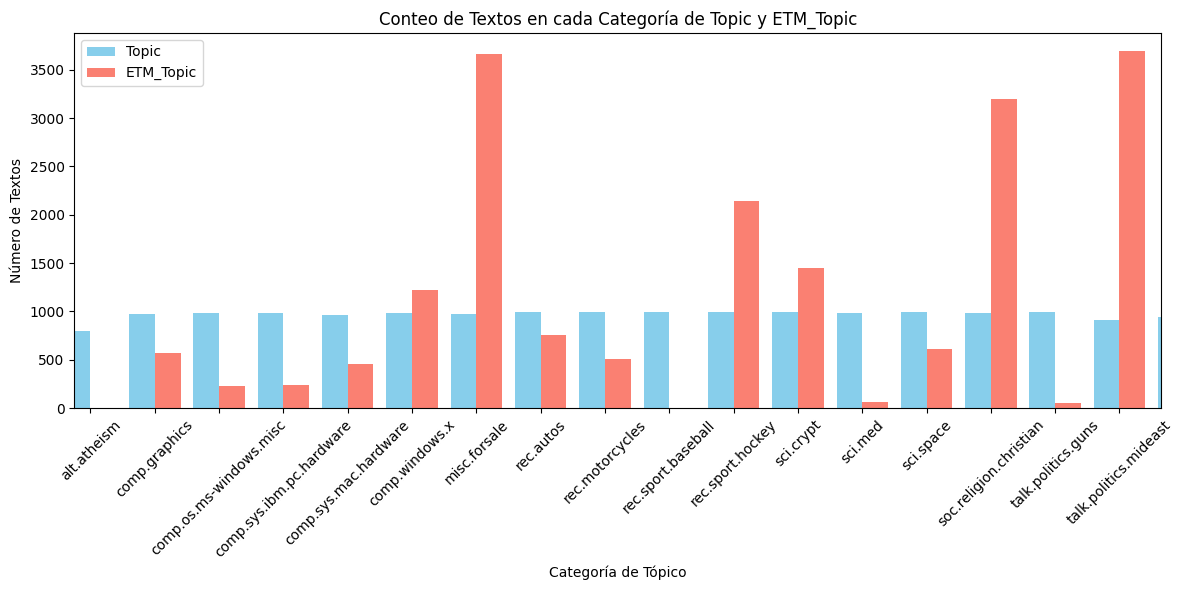

In [ ]:
import matplotlib.pyplot as plt

# Contar la cantidad de textos en cada categoría de 'topic' y 'etm_topic'
topic_counts = df_newsgroups['topic'].value_counts().sort_index()
etm_topic_counts = df_newsgroups['etm_topic'].value_counts().sort_index()

# Crear un gráfico de barras para las dos series de conteo
fig, ax = plt.subplots(figsize=(12, 6))
topic_counts.plot(kind='bar', color='skyblue', ax=ax, width=0.4, position=1, label='Topic')
etm_topic_counts.plot(kind='bar', color='salmon', ax=ax, width=0.4, position=0, label='ETM_Topic')

# Configurar etiquetas y título
plt.title("Conteo de Textos en cada Categoría de Topic y ETM_Topic")
plt.xlabel("Categoría de Tópico")
plt.ylabel("Número de Textos")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


# vMF para LSA

VAMOS a:

implementar un modelo vMF usando LSA en cada texto de la columna text del DataFrame df_newsgroups y guardar el resultado como una nueva columna. Usamos los topicos originales para modelar los temas con vMF.

Calculamos el porcentaje de documentos por topico que fueron asignados correctamente y la coherencia c_v.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Paso 1: Vectorización de los documentos con TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limita el vocabulario a 5000 palabras
tfidf_matrix = tfidf_vectorizer.fit_transform(df_newsgroups['text'])

# Paso 2: Reducir la dimensionalidad con LSA (TruncatedSVD)
lsa = TruncatedSVD(n_components=100)  # Usamos 100 componentes para tener embeddings de tamaño similar al de Doc2Vec
lsa_embeddings = lsa.fit_transform(tfidf_matrix)

# Paso 3: Normalizar cada embedding en una esfera (para que cada embedding esté en la superficie de una esfera unitaria)
lsa_embeddings_normalized = lsa_embeddings / np.linalg.norm(lsa_embeddings, axis=1, keepdims=True)

# Paso 4: Guardar los embeddings normalizados en el DataFrame
df_newsgroups['embedding'] = list(lsa_embeddings_normalized)



<ipython-input-16-e7f247c98d2b>:15: RuntimeWarning: invalid value encountered in divide
  lsa_embeddings_normalized = lsa_embeddings / np.linalg.norm(lsa_embeddings, axis=1, keepdims=True)


In [ ]:
df_newsgroups[:10]

,text,label,topic,lsa_vector,topic_encoded,etm_topic,embedding,assigned_topic
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey,"[0.6359957660601107, 0.2083566259060943, 0.027...",10,rec.sport.hockey,"[0.6522129617687243, 0.20818843274259372, 0.04...",rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware,"[0.22012323100654796, -0.19202761257125892, -0...",3,comp.sys.ibm.pc.hardware,"[0.23114423681248206, -0.19236254133730263, -0...",rec.sport.hockey
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast,"[0.7316726594899621, -0.12853336017140382, 0.2...",17,talk.politics.mideast,"[0.7368526059972198, -0.14229384131096223, 0.2...",rec.sport.hockey
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware,"[0.4712959238756603, 0.0719816206371337, -0.24...",3,comp.sys.ibm.pc.hardware,"[0.4858869408663623, 0.0870606222259549, -0.22...",rec.sport.hockey
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware,"[0.5029722845317334, -0.163536946497406, -0.27...",4,misc.forsale,"[0.5082691965026006, -0.16009134862167357, -0....",rec.sport.hockey
5,\n\nBack in high school I worked as a lab assi...,12,sci.electronics,"[0.5364562504066271, 0.044581710504533134, 0.0...",12,rec.sport.hockey,"[0.5473695206178496, 0.03767733700005716, 0.06...",rec.sport.hockey
6,\n\nAE is in Dallas...try 214/241-6060 or 214/...,4,comp.sys.mac.hardware,"[0.3936657159132328, -0.16637825857365476, 0.0...",4,rec.sport.hockey,"[0.3894213820703949, -0.17420813999432724, 0.0...",rec.sport.hockey
7,"\n[stuff deleted]\n\nOk, here's the solution t...",10,rec.sport.hockey,"[0.5354382070379378, 0.05402878347780897, -0.0...",10,misc.forsale,"[0.5414207242248801, 0.045373201007867014, -0....",rec.sport.hockey
8,"\n\n\nYeah, it's the second one. And I believ...",10,rec.sport.hockey,"[0.5257264377621984, 0.0016473236060151855, 0....",10,misc.forsale,"[0.5226548803177157, -0.003143634027755658, 0....",rec.sport.hockey
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc,"[0.3679218593322698, 0.050728106741922234, 0.0...",19,soc.religion.christian,"[0.4582614406899488, 0.062017502721611634, 0.0...",rec.sport.hockey


In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Paso 1: Vectorización de los documentos con TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_newsgroups['text'])

# Paso 2: Reducir la dimensionalidad con LSA (TruncatedSVD)
lsa = TruncatedSVD(n_components=100)
lsa_embeddings = lsa.fit_transform(tfidf_matrix)

# Paso 3: Normalizar cada embedding en una esfera y manejar normas cero
norms = np.linalg.norm(lsa_embeddings, axis=1, keepdims=True)
norms[norms == 0] = 1  # Evitar división por cero reemplazando norma cero por uno
lsa_embeddings_normalized = lsa_embeddings / norms

# Paso 4: Guardar los embeddings normalizados en el DataFrame
df_newsgroups['embedding'] = list(lsa_embeddings_normalized)

# Calcular los centroides basados en los tópicos en 'topic'
unique_topics = df_newsgroups['topic'].unique()
centroides_temas = {}

for topic in unique_topics:
    # Obtener los embeddings de los documentos para el tema actual
    embeddings_tema = np.stack(df_newsgroups[df_newsgroups['topic'] == topic]['embedding'].values)

    # Calcular el centroide normalizado para el tema y manejar normas cero
    centroide = np.mean(embeddings_tema, axis=0)
    if np.linalg.norm(centroide) == 0:  # Si el centroide tiene norma cero
        centroide = np.ones(centroide.shape)  # Asignar un vector de unos como neutral
    else:
        centroide = centroide / np.linalg.norm(centroide)  # Normalizar el centroide
    centroides_temas[topic] = centroide

# Asignación de temas basada en la similitud con cada centroide
assigned_topics = []

for embedding in df_newsgroups['embedding']:
    # Calcular la similitud (producto punto) con cada centroide
    similitudes = {topic: np.dot(embedding, centroide) for topic, centroide in centroides_temas.items()}
    # Asignar el tema con la mayor similitud
    assigned_topic = max(similitudes, key=similitudes.get)
    assigned_topics.append(assigned_topic)

# Agregar la asignación de temas al DataFrame
df_newsgroups['assigned_topic'] = assigned_topics

# Mostrar los primeros resultados
print(df_newsgroups[['text', 'topic', 'assigned_topic']].head())


                                                text  \
0  \n\nI am sure some bashers of Pens fans are pr...   
1  My brother is in the market for a high-perform...   
2  \n\n\n\n\tFinally you said what you dream abou...   
3  \nThink!\n\nIt's the SCSI card doing the DMA t...   
4  1)    I have an old Jasmine drive which I cann...   

                      topic            assigned_topic  
0          rec.sport.hockey          rec.sport.hockey  
1  comp.sys.ibm.pc.hardware  comp.sys.ibm.pc.hardware  
2     talk.politics.mideast        talk.politics.misc  
3  comp.sys.ibm.pc.hardware  comp.sys.ibm.pc.hardware  
4     comp.sys.mac.hardware  comp.sys.ibm.pc.hardware  


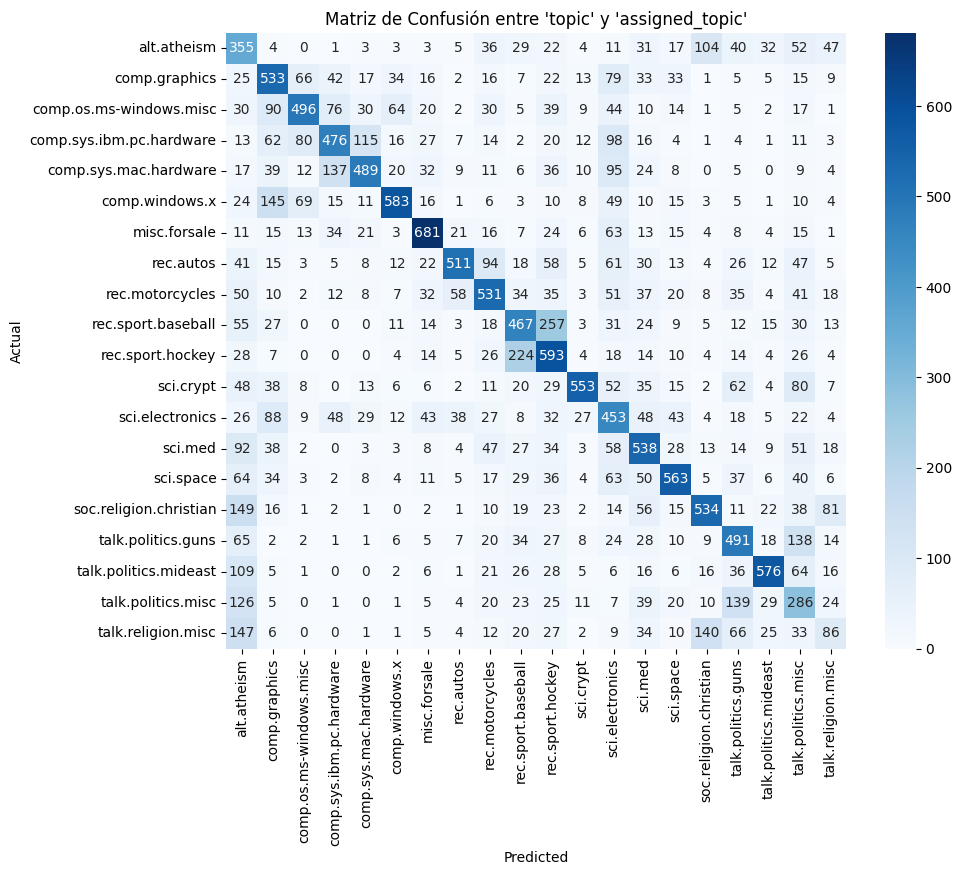

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear la tabla de contingencia como matriz de confusión
matriz_confusion = pd.crosstab(df_newsgroups['topic'], df_newsgroups['assigned_topic'], rownames=['Actual'], colnames=['Predicted'])

# Plotear la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Matriz de Confusión entre 'topic' y 'assigned_topic'")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


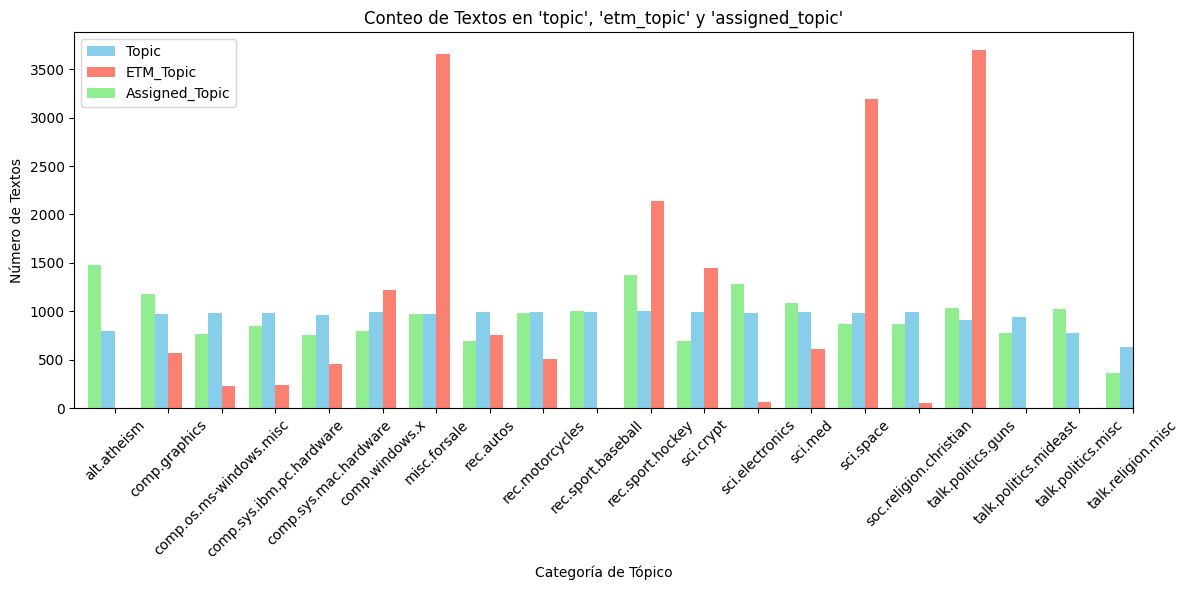

In [ ]:
import matplotlib.pyplot as plt

# Contar la cantidad de textos en cada categoría de 'topic', 'etm_topic' y 'assigned_topic'
topic_counts = df_newsgroups['topic'].value_counts().sort_index()
etm_topic_counts = df_newsgroups['etm_topic'].value_counts().sort_index()
assigned_topic_counts = df_newsgroups['assigned_topic'].value_counts().sort_index()

# Crear un gráfico de barras
fig, ax = plt.subplots(figsize=(12, 6))

# Plotear los conteos de 'topic', 'etm_topic' y 'assigned_topic'
topic_counts.plot(kind='bar', color='skyblue', ax=ax, width=0.25, position=1, label='Topic')
etm_topic_counts.plot(kind='bar', color='salmon', ax=ax, width=0.25, position=0, label='ETM_Topic')
assigned_topic_counts.plot(kind='bar', color='lightgreen', ax=ax, width=0.25, position=2, label='Assigned_Topic')

# Configurar etiquetas y título
plt.title("Conteo de Textos en 'topic', 'etm_topic' y 'assigned_topic'")
plt.xlabel("Categoría de Tópico")
plt.ylabel("Número de Textos")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [ ]:
# Contar coincidencias exactas entre 'topic' y 'assigned_topic'
coincidencias = (df_newsgroups['topic'] == df_newsgroups['assigned_topic']).sum()

# Calcular la accuracy dividiendo las coincidencias por el total de documentos
accuracy = coincidencias / len(df_newsgroups)

# Mostrar el resultado
print(f"La accuracy es: {accuracy:.4f}")


La accuracy es: 0.5197
